
## Task 2: Agricultural pest recognition with image data

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

The business problem for this task deals with the identification of agricultural pests images and classifying them in the categories of ants, bees, grasshopper, moth and wasp. The images provided are used to train two CNN models (convolutional neural network) with different number of kernels, kernel sizes and convolutional layers. The two models are compared based on their performances and the results show that the best of the model can correctly classify the pest 62% of the times. The better performing model has 1 convolutional layer compared to its counterpart with 3 convolutional layers and more training parameters. The images of the ants and grasshopper were not very accurately classified and need better images to improve model performance. The model performance decreases with over-training and thus it is better to keep it moderately trained.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

Data preprocessing for this task involves platform preparation, data loading and data preparation. The selected GPU for the notebook is T4 GPU. T4 GPUs are well-suited for training and running deep learning models. Operations involved in neural networks can be parallelized, allowing GPUs to significantly accelerate the training process. The image files of ants, bees, grasshopper, moth and wasp are loaded. After loading the files, each image file is attached with a label, shuffled and splitted into training and testing sets of 70:30. The dataframes are then converted into arrays and value of each pixel for each image is normalised for the neural networks. It is done using X_train/=255, x_test/=255 beacause image data has 256 intensities of the colors which has to be normalised between 0 to 1. The shape of training set for x is (1735,100,100,3) which means there are 1735 images with sizes 100X100 made up of 3 colors red, blue and green or channels and for y is (1735,5) which means 1735 records and 5 image classes, ants, bees, grasshopper, moth and wasp. After assigning categories to the pests, the images are printed to observe how they look.

Setting runtime type to T4 GPU and importing important libraries

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

In [ ]:
import math
import pandas as pd
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf
import os
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback
from keras.optimizers import SGD, RMSprop, Adam, Nadam, Adadelta
from keras.losses import categorical_crossentropy
from keras import regularizers

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Defining functions to plot images and plot history

In [ ]:
def plot_images(ims, figsize=(12,12), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

Loading the data of image files and storing the images with labels.

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
ants_path='/content/drive/MyDrive/Colab Notebooks/dataset/ants'
bees_path='/content/drive/MyDrive/Colab Notebooks/dataset/bees'
grasshopper_path='/content/drive/MyDrive/Colab Notebooks/dataset/grasshopper'
moth_path='/content/drive/MyDrive/Colab Notebooks/dataset/moth'
wasp_path='/content/drive/MyDrive/Colab Notebooks/dataset/wasp'
ants_file_list=os.listdir(ants_path)
bees_file_list=os.listdir(bees_path)
grasshopper_file_list=os.listdir(grasshopper_path)
moth_file_list=os.listdir(moth_path)
wasp_file_list=os.listdir(wasp_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a list to store the image data and labels
data = []

# Iterate through the files in the first folder
for file in os.listdir(ants_path):
  # Check if the file is a png or jpg file
  if file.endswith('.png') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(ants_path, file))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    # Assign 'ants' label to the file
    label = 'ants'
    # Add the image data and label to the data list
    data.append((img, label))

# Iterate through the files in the second folder
for file in os.listdir(bees_path):
  # Check if the file is a png or jpg file
  if file.endswith('.png') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(bees_path, file))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    # Assign 'bees' label to the file
    label = 'bees'
    # Add the image data and label to the data list
    data.append((img, label))

# Iterate through the files in the third folder
for file in os.listdir(grasshopper_path):
  # Check if the file is a png or jpg file
  if file.endswith('.png') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(grasshopper_path, file))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    # Assign 'grasshopper' label to the file
    label = 'grasshopper'
    # Add the image data and label to the data list
    data.append((img, label))

# Iterate through the files in the fourth folder
for file in os.listdir(moth_path):
  # Check if the file is a png or jpg file
  if file.endswith('.png') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(moth_path, file))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    # Assign 'moth' label to the file
    label = 'moth'
    # Add the image data and label to the data list
    data.append((img, label))

# Iterate through the files in the fifth folder
for file in os.listdir(wasp_path):
  # Check if the file is a png or jpg file
  if file.endswith('.png') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(wasp_path, file))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    # Assign 'wasp' label to the file
    label = 'wasp'
    # Add the image data and label to the data list
    data.append((img, label))

In [ ]:
# Shuffle the data and split into train/test sets of 70:30.
random.shuffle(data)
train_data, test_data = data[:int(len(data) * 0.7)], data[int(len(data) * 0.7):]

In [ ]:
from tensorflow.keras.utils import to_categorical
img_rows=100
img_cols=100
channels=3
num_classes=5
# Extract the image data and labels from the training data
X_train, Y_train = zip(*train_data)

# Extract the image data and labels from the testing data
X_test, Y_test = zip(*test_data)

# Convert the image data and labels into NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [ ]:
# change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize each value for each pixel for the entire vector for each input
X_train /= 255
X_test /= 255

# print the shape of the reshaped data
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (1735, 100, 100, 3)
Testing matrix shape (744, 100, 100, 3)


In [ ]:
print('The original format of class of the first element in the training dataset is: ',Y_train[0], '\n')

import numpy as np
# Create a NumPy array with category strings
categories = np.array(['ants','bees','grasshopper','moth','wasp'])

# Create a mapping from category strings to integers
category_map = {'ants':0,'bees':1,'grasshopper':2,'moth':3,'wasp':4}

# Encode the categories for plotting images
Y_train_print = np.array([category_map[category] for category in Y_train])
Y_test_print = np.array([category_map[category] for category in Y_test])

print('The unique integer mapping encoding format of the class of the first element in the training dataset is: ',Y_train[0])

The original format of class of the first element in the training dataset is:  bees 

The unique integer mapping encoding format of the class of the first element in the training dataset is:  bees


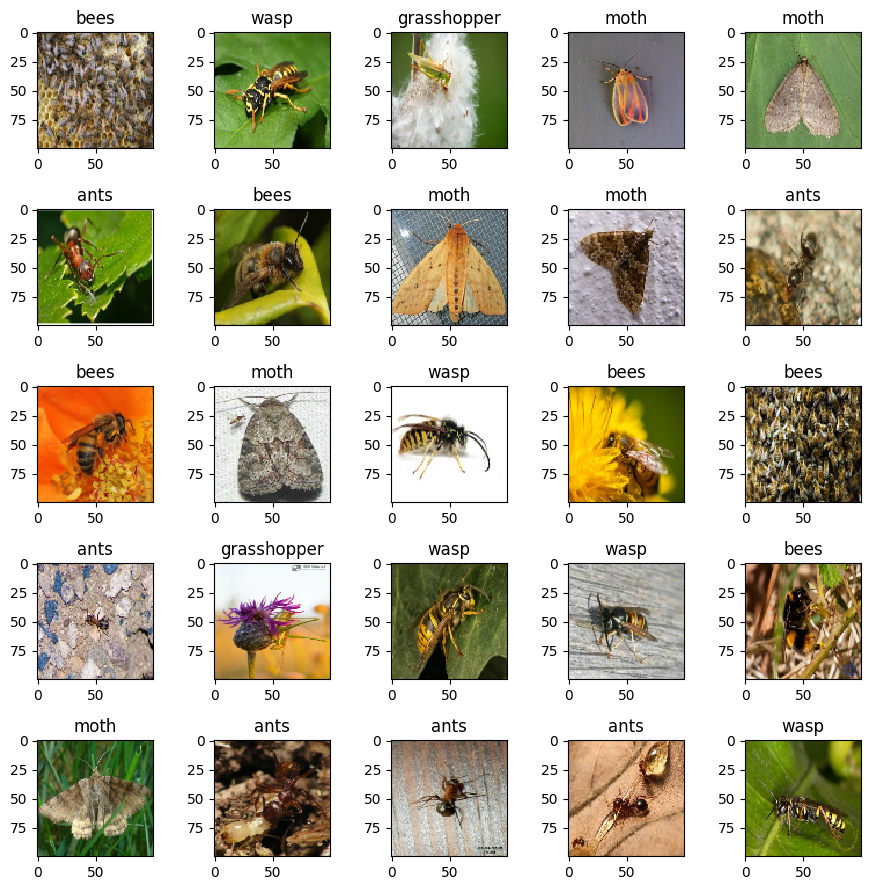

In [ ]:
# change the default figure size for all plots created in the program
plt.rcParams['figure.figsize'] = (9,9)

labels =  ['ants','bees','grasshopper','moth','wasp']

for i in range(25):
    # plt.subplot() function takes three integer arguments: the number of rows, the number of columns, and the index of the subplot.
    plt.subplot(5,5,i+1)
    # plt.imshow() function displays the image at index i in the X_train array as a grayscale image, with no interpolation applied.
    plt.imshow(X_train[i], interpolation='none')
    plt.title("{}".format(labels[int(Y_train_print[i])]))

plt.tight_layout()

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Example labels
categories = ['ants','bees','grasshopper','moth','wasp']

# Create a label encoder
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# Convert string labels to integer labels
Y_train_encoded = label_encoder.transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Convert integer labels to one-hot encoded format
num_classes = len(categories)
Y_train_onehot = to_categorical(Y_train_encoded, num_classes)
Y_test_onehot = to_categorical(Y_test_encoded, num_classes)
print('Train shape: x=',X_train.shape,',y=', Y_train_onehot.shape)
print('Test shape: x=',X_test.shape,',y=', Y_test_onehot.shape)

Train shape: x= (1735, 100, 100, 3) ,y= (1735, 5)
Test shape: x= (744, 100, 100, 3) ,y= (744, 5)


<a id = "cell_model"></a>
## 3. Predictive Modeling

1. The first CNN model, has 3 convolution layers with 32, 64 and 128 kernels, these kernels have following sizes (2,2),(2,2),(3,3) respectively. After the convolution layers, there is one pooling layer of size (2,2). There is only one hidden layer with 128 nodes and activation function 'relu' with dropout layers that drop 25 and 50% of the nodes in between. The final output layer has 5 nodes for the 5 classes. A callback function is used based on 'val_loss' with patience= 20 that is, the execution will stop after 20 iterations after the 'val_loss' doesn't improve.

Looking at the parameters, for convolution layers, parameters= (number of kernels)x(kernel_width)x(kernel_height) and for the dense layers parameters=(input_nodes+1)xoutput_size.

Thus, for first conv2D layer, parameters= 32x(2x2x3 + 1)= 416. For the second conv2D layer, parameters= 64x(2x2x32 +1)= 8256. For the third conv2D layer, parameters= 128x(3x3x64 +1)= 73856.

The number of nodes after flattening is 294912= 128x48x48. For the hidden dense layer, parameters= (294912+1)x 128= 37748864. And for the final layer, parameters= (128+1)x5=645


Also random seed of 2023 is used. The optimiser used for the model is Nadam with learning_rate=0.002.

In [ ]:
seed_value = 2023
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def model_1():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2),
                     activation='relu',
                     input_shape=(100, 100, 3)))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=(100, 100, 3)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model
# Keras callbacks (when Tensorboard installed)
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
model=model_1()
model.compile(loss=categorical_crossentropy,
              optimizer=Nadam(learning_rate=0.002),
              metrics='accuracy')

hist = model.fit(X_train, Y_train_onehot,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, Y_test_onehot),
      validation_split=0.3,
      callbacks=keras_callbacks)
# Evaluate on training data
train_score = model.evaluate(X_train, Y_train_onehot, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, Y_test_onehot, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 99, 99, 32)        416       
                                                                 
 conv2d_10 (Conv2D)          (None, 98, 98, 64)        8256      
                                                                 
 conv2d_11 (Conv2D)          (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 48, 48, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 294912)            0         
                                                      

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(Y_test_onehot, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= ['ants','bees','grasshopper','moth','wasp'])

# Print the report
print("The result of the classification report is: \n ",report)

24/24 [==============================] - 0s 15ms/step
The result of Kappa is : 0.379
The result of the classification report is: 
                precision    recall  f1-score   support

        ants       0.49      0.38      0.43       142
        bees       0.41      0.59      0.48       150
 grasshopper       0.47      0.32      0.38       168
        moth       0.65      0.58      0.61       146
        wasp       0.54      0.68      0.60       138

    accuracy                           0.50       744
   macro avg       0.51      0.51      0.50       744
weighted avg       0.51      0.50      0.50       744



2. The second CNN model, has one convolution layer with 32 kernels of size (3,3). After the convolution layer, there is one pooling layer of size (3,3). There is only one hidden layer with 128 nodes and activation function 'relu'with dropout layers that drop 25 and 50% of the nodes in between. The final output layer has 5 nodes for the 5 classes. A callback function is used based on 'val_loss' with patience= 20 that is, the execution will stop after 20 iterations after the 'val_loss' doesn't improve.

Looking at the parameters, for convolution layers, parameters= (number of kernels)x(kernel_width)x(kernel_height) and for the dense layers parameters=(input_nodes+1)xoutput_size.

Thus, for first conv2D layer, parameters= 32x(3x3x3 + 1)= 896.

The number of nodes after flattening is 32768= 32x32x32. For the hidden dense layer, parameters= (32768+1)x 128= 4194432. And for the final layer, parameters= (128+1)x5=645


Also random seed of 2023 is used. The optimiser used for the model is Nadam with learning_rate=0.002.

In [ ]:
seed_value = 2023
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
def model_2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(img_rows, img_cols, channels)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model
# Keras callbacks (when Tensorboard installed)
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
model=model_2()
model.compile(loss=categorical_crossentropy,
              optimizer=Nadam(learning_rate=0.002),
              metrics='accuracy')

hist = model.fit(X_train, Y_train_onehot,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, Y_test_onehot),
      validation_split=0.3,
      callbacks=keras_callbacks)
# Evaluate on training data
train_score = model.evaluate(X_train, Y_train_onehot, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, Y_test_onehot, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 flatten_25 (Flatten)        (None, 32768)             0         
                                                                 
 dense_50 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                     

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(Y_test_onehot, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= ['ants','bees','grasshopper','moth','wasp'])

# Print the report
print("The result of the classification report is: \n ",report)

24/24 [==============================] - 0s 4ms/step
The result of Kappa is : 0.528
The result of the classification report is: 
                precision    recall  f1-score   support

        ants       0.43      0.65      0.52       143
        bees       0.68      0.68      0.68       165
 grasshopper       0.66      0.38      0.49       149
        moth       0.71      0.79      0.75       136
        wasp       0.76      0.61      0.68       151

    accuracy                           0.62       744
   macro avg       0.65      0.62      0.62       744
weighted avg       0.65      0.62      0.62       744



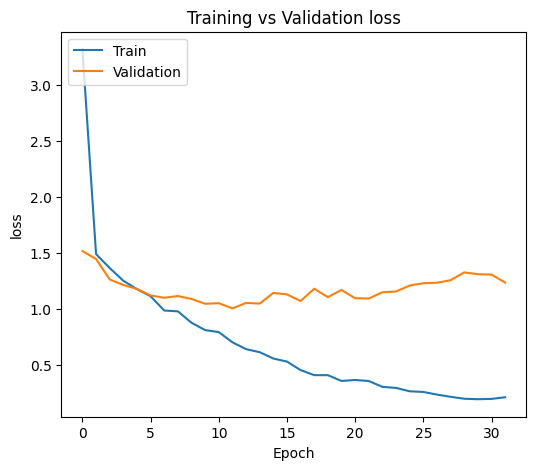

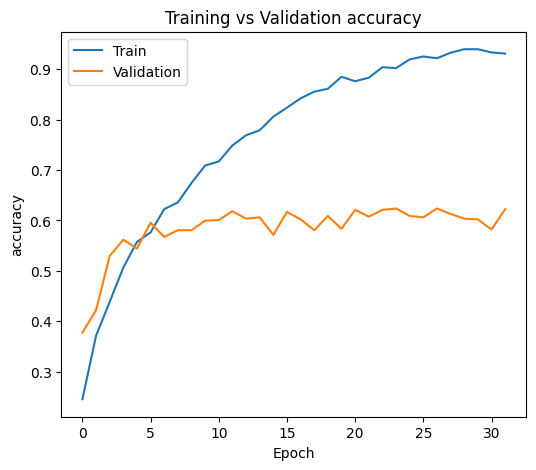

In [ ]:
plot_hist(pd.DataFrame(hist.history))

Comparing the two CNN models:
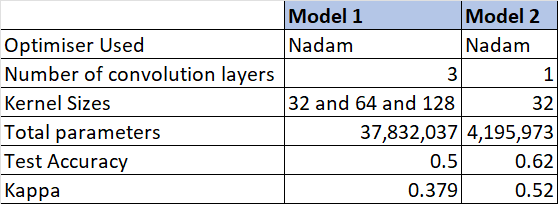

Both the models have nearly 1 training accuracy but the first model has 3 convolution layers and much more parameters compared to the second model, thus over-training is making the first model less accurate at test data set.

As per the output predictions, first model has difficulty in predicting ants, grasshoppers and bees.For them precision is low and aslo the f1 scores. For the second model, the f1 scores for ants and grasshopper are around 0.5 which are making the model precision low for these two pests. The images of ants, grasshoppers and bees need to be improved in order to improve the pest prediction. Probably due to the presence of flowers, leaves and other backgrounds, the images of ants and grasshoppers are not accurately identified.

<a id = "cell_model"></a>
## 4. Experiments Report

Following experiments were performed on the number of kernels, kernel sizes and optimisers:


1.   The more the number of kernels, more trained the model is and less accurate it becomes on the test dataset.
2.   For the given pest images, Nadam optimiser is the better than RMSprop,Adadelta, and Adam.
3. The models can be used to identify pests at an accuracy of 61% and thus prevent crop and agricultural damage to the farmlands.
4. More the number of parameters, better the model training, this is wrong understanding and thus multiple experiments are to performed with respect to model parameters.
5. The images of ants and grasshoppers need to be improved because they are least accurately predicted, because of the background, presence of flowers, leaves, and other unimportant pixel information.


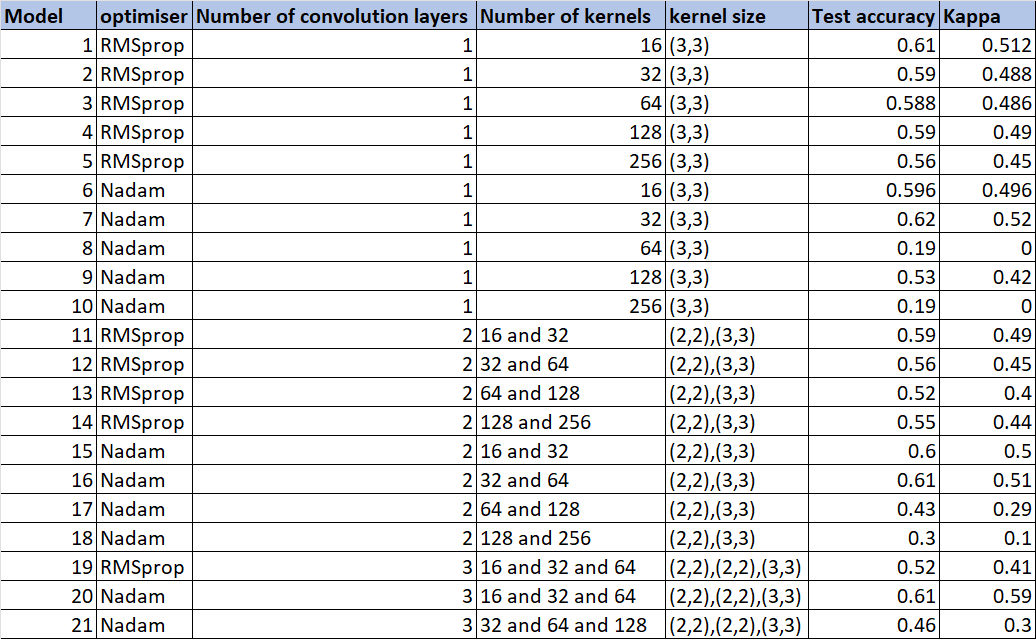